In [2]:
# pyspark --conf “spark.ui.port=10101”

!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.3MB 73kB/s 
     |████████████████████████████████| 204kB 44.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=fa2780637a3776ef9356766b5407e685c8571f1e5afe7d6aa818eddfb72e0133
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this 

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [108]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.functions import monotonically_increasing_id

In [147]:
sc = SparkContext.getOrCreate()
sc.stop()

# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

# Problem 2 -- k-means on Spark

a1)


#### Tools

In [175]:
def distance_e(list1, list2):
  squares = [(p-q) ** 2 for p, q in zip(list1, list2)]
  return np.sum(squares) ** 0.5

def distance_m(list1, list2):
  absolute = [np.abs(p-q) for p, q in zip(list1, list2)]
  return np.sum(absolute)

def sort(grouped):
  sort = sorted(grouped, key = lambda x : x[1])[:1] 
  return sort

#### Import data

In [149]:
data = sc.textFile("data.txt")
data = data.map(lambda line: tuple([float(x) for x in line.split(" ")])).zipWithIndex()

In [177]:
initial_c1 = sc.textFile("c1.txt")
c1 = initial_c1.map(lambda line: [float(x) for x in line.split(" ")])

In [196]:
initial_c2 = sc.textFile("c2.txt")
c2 = initial_c2.map(lambda line: [float(x) for x in line.split(" ")])

#### Main -- iterations

In [197]:
max_iter = 20
k = 10

costs_c2_manh = []
for i in range(21):

  # assign points to clusters

  merged = data.cartesian(c2)
  #print(merged.count())
  #dist = merged.map(lambda pair: [tuple(pair[0]), (tuple(pair[1]), distance_e(pair[0][0], pair[1]))])
  dist = merged.map(lambda pair: [tuple(pair[0]), (tuple(pair[1]), distance_m(pair[0][0], pair[1]))])
  #print(dist.count())
  assigned = dist.groupByKey().mapValues(list).map(lambda pair: (pair[0][0], sort(pair[1])))
  #print(assigned.count())
  
  # centroids
  centroids = assigned.map(lambda x : (x[1][0][0], x[0]))
  centroids_grouped = centroids.groupByKey().mapValues(list)
  #print(centroids_grouped.count())
  
  # min_dist
  #min_dist = assigned.map(lambda x : x[1][0][1]**2).sum()
  min_dist = assigned.map(lambda x : x[1][0][1]).sum()
  
  # cost
  cost = min_dist
  costs_c2_manh.append(cost) 

  # recompute the centroids
  recompute = centroids_grouped.map(lambda x : (x[0], list(np.mean(x[1], axis = 0))))
  new = recompute.map(lambda x : x[1]).collect()
  c2 = sc.parallelize(new)
  #print(i)


### Eucliedan distance

In [164]:
(costs_c1_eucl[0] - costs_c1_eucl[10]) / costs_c1_eucl[0]

0.2648391714456047

In [167]:
(costs_c2_eucl[0] - costs_c2_eucl[10]) / costs_c2_eucl[0]

0.7669795594605944

##### Plot

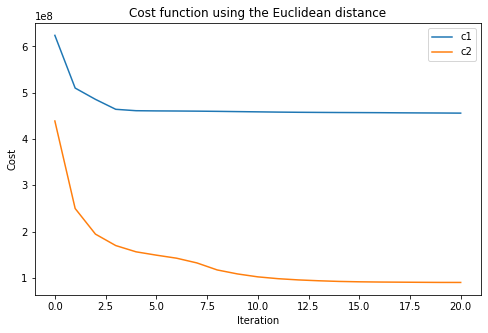

In [190]:
plt.figure(figsize=(8,5))

x = [i for i in range(21)]
y1 = costs_c1_eucl
y2 = costs_c2_eucl

plt.plot(x, y1) 
plt.plot(x, y2) 

plt.title('Cost function using the Euclidean distance')
plt.legend(["c1", "c2"])

plt.ylabel('Cost')
plt.xlabel('Iteration')

plt.savefig("eucl.png")
plt.show()

### Manhattan distance

In [179]:
(costs_c1_manh[0] - costs_c1_manh[10]) / costs_c1_manh[0]

0.18654926116799223

In [193]:
(costs_c2_manh[0] - costs_c2_manh[10]) / costs_c2_manh[0]

0.5155409910238908

##### Plot

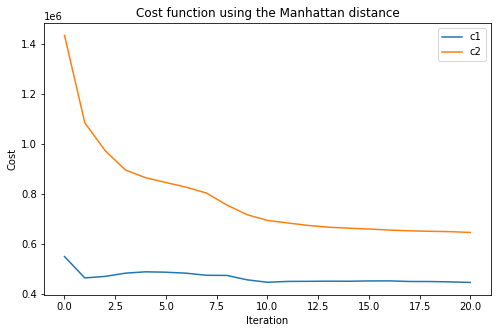

In [194]:
plt.figure(figsize=(8,5))

x = [i for i in range(21)]
y1 = costs_c1_manh
y2 = costs_c2_manh

plt.plot(x, y1) 
plt.plot(x, y2) 

plt.title('Cost function using the Manhattan distance')
plt.legend(["c1", "c2"])

plt.ylabel('Cost')
plt.xlabel('Iteration')

plt.savefig("manh.png")
plt.show()